In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from functorch import make_functional, vmap, grad, jacrev
import functools

from pyDOE import lhs

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


In [3]:
class Plain(nn.Module):
    
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def compute_loss_Res(func_params, X_inner, Rf_inner):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    grad2_f = (jacrev(grad(f)))(X_inner, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    
    laplace = (dudX2[0] + dudX2[1] + dudX2[2] + dudX2[3] + dudX2[4] + dudX2[5])
    
    loss_Res = laplace - Rf_inner

    return loss_Res.flatten()


def compute_loss_b(func_params, X_bd, U_bd):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    u_pred = f(X_bd, func_params)
    loss_b = u_pred - U_bd
        
    return loss_b.flatten()

def compute_loss_j(func_params, X_ij, Uj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)

    ij_outer = torch.cat((X_ij[0], X_ij[1], X_ij[2], X_ij[3], X_ij[4], X_ij[5], 1.0+0.0*X_ij[0]), 0)
    ij_inner = torch.cat((X_ij[0], X_ij[1], X_ij[2], X_ij[3], X_ij[4], X_ij[5], -1.0+0.0*X_ij[0]), 0)

    u_ij_outer = f(ij_outer, func_params)
    u_ij_inner = f(ij_inner, func_params)
    
    ij_pred = u_ij_outer - u_ij_inner
    
    loss_j = ij_pred - Uj_ij
        
    return loss_j.flatten()

def compute_loss_normal_jump(func_params, X_ij, Unj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)
    
    ij_outer = torch.cat((X_ij[0], X_ij[1], X_ij[2], X_ij[3], X_ij[4], X_ij[5], 1.0+0.0*X_ij[0]), 0)
    ij_inner = torch.cat((X_ij[0], X_ij[1], X_ij[2], X_ij[3], X_ij[4], X_ij[5], -1.0+0.0*X_ij[0]), 0)

    grad_f_outer = (grad(f))(ij_outer, func_params)
    df_outer = (grad_f_outer)
    Normal_outer = (df_outer[0]*X_ij[0]+df_outer[1]*X_ij[1]+df_outer[2]*X_ij[2]+df_outer[3]*X_ij[3]+df_outer[4]*X_ij[4]+df_outer[5]*X_ij[5])/torch.sqrt(X_ij[0]**2+X_ij[1]**2+X_ij[2]**2+X_ij[3]**2+X_ij[4]**2+X_ij[5]**2)
    grad_f_inner = (grad(f))(ij_inner, func_params)
    df_inner = (grad_f_inner)
    Normal_inner = (df_inner[0]*X_ij[0]+df_inner[1]*X_ij[1]+df_inner[2]*X_ij[2]+df_inner[3]*X_ij[3]+df_inner[4]*X_ij[4]+df_inner[5]*X_ij[5])/torch.sqrt(X_ij[0]**2+X_ij[1]**2+X_ij[2]**2+X_ij[3]**2+X_ij[4]**2+X_ij[5]**2)
    
    normal_jump_pred = 1.0e-3*Normal_outer - Normal_inner

    loss_normal_jump = normal_jump_pred - Unj_ij
        
    return loss_normal_jump.flatten()

In [5]:
def exact_u(X):
  z = X[:, 6:7]
  # exact_u = exact solution
  # if z= 1 -> u1
  u1 = np.sin(X[:,0:1])*np.sin(X[:,1:2])*np.sin(X[:,2:3])*np.sin(X[:,3:4])*np.sin(X[:,4:5])*np.sin(X[:,5:6])
  # if z=-1 -> fn1
  un1 = np.exp(X[:,0:1]+X[:,1:2]+X[:,2:3]+X[:,3:4]+X[:,4:5]+X[:,5:6])
  eu = u1*(z+1.0)/2.0 + un1*(1.0-z)/2.0
  return eu

def rhs_f(X_inner):
  # exact_u = exact solution
  # if z= 1 -> u1
  f1 = -6.0*np.sin(X_inner[:,0:1])*np.sin(X_inner[:,1:2])*np.sin(X_inner[:,2:3])*np.sin(X_inner[:,3:4])*np.sin(X_inner[:,4:5])*np.sin(X_inner[:,5:6])
  # if z=-1 -> fn1
  fn1 = 6.0*np.exp(X_inner[:,0:1]+X_inner[:,1:2]+X_inner[:,2:3]+X_inner[:,3:4]+X_inner[:,4:5]+X_inner[:,5:6])
  rf = f1*(X_inner[:,6:7]+1.0)/2.0 + fn1*(1.0-X_inner[:,6:7])/2.0
  return rf

def normal_u(X):
  x = X[:, 0:10]
  z = X[:, 10]
  # exact_u = exact solution
  # if z= 1 -> u1
  u1 = (X[:,0]*X[:,1])*(X[:,0]**8 + X[:,1]**8) + (X[:,2]*X[:,3])*(X[:,2]**8 + X[:,3]**8) + X[:,4]*X[:,5]*(X[:,4]**8 + X[:,5]**8) + X[:,6]*X[:,7]*(X[:,6]**8 +X[:,7]**8) + X[:,8]*X[:,9]*(X[:,8]**8+X[:,9]**8)
  u1 = u1/np.sqrt(x**2 + y**2)
  # if z=-1 -> fn1
  un1 = (x+y)*np.exp(x+y)
  un1 = un1/np.sqrt(x**2 + y**2)
  nu = u1*(z+1.0)/2.0 + un1*(1.0-z)/2.0
  return nu

def normal_u(x0, x1, x2, x3, x4, x5, z):
  # exact_u = exact solution
  # if z= 1 -> u1
  u1 = np.cos(x0)*np.sin(x1)*np.sin(x2)*np.sin(x3)*np.sin(x4)*np.sin(x5)*x0\
  +np.sin(x0)*np.cos(x1)*np.sin(x2)*np.sin(x3)*np.sin(x4)*np.sin(x5)*x1\
  +np.sin(x0)*np.sin(x1)*np.cos(x2)*np.sin(x3)*np.sin(x4)*np.sin(x5)*x2\
  +np.sin(x0)*np.sin(x1)*np.sin(x2)*np.cos(x3)*np.sin(x4)*np.sin(x5)*x3\
  +np.sin(x0)*np.sin(x1)*np.sin(x2)*np.sin(x3)*np.cos(x4)*np.sin(x5)*x4\
  +np.sin(x0)*np.sin(x1)*np.sin(x2)*np.sin(x3)*np.sin(x4)*np.cos(x5)*x5
  dist = np.sqrt(x0**2 + x1**2 + x2**2+x3**2 + x4**2 + x5**2)
  u1 = u1/dist
  # if z=-1 -> fn1
  un1 = (x0+x1+x2+x3+x4+x5)*np.exp(x0+x1+x2+x3+x4+x5)
  un1 = un1/dist
  nu = u1*(z+1.0)/2.0 + un1*(1.0-z)/2.0
  return nu

def sign_x(X):
  z = 0.0*X[:,0:1] + 1.0
  for i in range(len(z)):
    dist = np.linalg.norm(X[i,:], 2)
    if dist < 0.5:
      z[i] = -1.0
  return z

In [6]:
d = 6

# number of grid points
N_inner = 100
N_bd = 141
N_ij = 141

# Training points

## X_inner: points inside the domain, totally (N_inner-1)**2 points
para_inner = lhs(d, N_inner)
r = np.sqrt(para_inner[:,0:1]*0.36)
t1 = para_inner[:,1:2]*np.pi
t2 = para_inner[:,2:3]*np.pi
t3 = para_inner[:,3:4]*np.pi
t4 = para_inner[:,4:5]*np.pi
t5 = para_inner[:,5:6]*2.0*np.pi
X_inner = 0.0*para_inner
X_inner[:, 0:1] = r*np.cos(t1)
X_inner[:, 1:2] = r*np.sin(t1)*np.cos(t2)
X_inner[:, 2:3] = r*np.sin(t1)*np.sin(t2)*np.cos(t3)
X_inner[:, 3:4] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.cos(t4)
X_inner[:, 4:5] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.cos(t5)
X_inner[:, 5:6] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.sin(t5)
z_inner = sign_x(X_inner)
X_inner = np.hstack([X_inner, z_inner])
Rf_inner = rhs_f(X_inner)
Rf_inner = Rf_inner.reshape(N_inner, 1)

## X_bd: points at the boundary, totally N_bd points
para_bd = lhs(d, N_bd)
r = 0.6
t1 = para_bd[:,1:2]*np.pi
t2 = para_bd[:,2:3]*np.pi
t3 = para_bd[:,3:4]*np.pi
t4 = para_bd[:,4:5]*np.pi
t5 = para_bd[:,5:6]*2.0*np.pi
X_bd = 0.0*para_bd
X_bd[:, 0:1] = r*np.cos(t1)
X_bd[:, 1:2] = r*np.sin(t1)*np.cos(t2)
X_bd[:, 2:3] = r*np.sin(t1)*np.sin(t2)*np.cos(t3)
X_bd[:, 3:4] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.cos(t4)
X_bd[:, 4:5] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.cos(t5)
X_bd[:, 5:6] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.sin(t5)
X_bd = np.hstack([X_bd, 0.0*X_bd[:,0:1]+1.0])

## U_bd: function values at the boundary, totally 2*d*N_bd points
U_bd = exact_u(X_bd)
U_bd = U_bd.reshape(N_bd, 1)

## X_ij: points at the interior interface, totally N_ij points
para_ij = lhs(d, N_bd)
r = 0.5
t1 = para_ij[:,1:2]*np.pi
t2 = para_ij[:,2:3]*np.pi
t3 = para_ij[:,3:4]*np.pi
t4 = para_ij[:,4:5]*np.pi
t5 = para_ij[:,5:6]*2.0*np.pi
X_ij = 0.0*para_ij
X_ij[:, 0:1] = r*np.cos(t1)
X_ij[:, 1:2] = r*np.sin(t1)*np.cos(t2)
X_ij[:, 2:3] = r*np.sin(t1)*np.sin(t2)*np.cos(t3)
X_ij[:, 3:4] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.cos(t4)
X_ij[:, 4:5] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.cos(t5)
X_ij[:, 5:6] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.sin(t5)

## Uj_ij: function jump at the interior interface, totally 2*d*N_bd points
Uj_ij = exact_u(np.hstack([X_ij, 0.0*X_ij[:,0:1]+1.0])) - exact_u(np.hstack([X_ij, 0.0*X_ij[:,0:1]-1.0]))
Uj_ij = Uj_ij.reshape(N_ij, 1)

# beta_plus
beta_plus = 1.0e-3
## Unj_ij: normal jump at the interior interface, totally N_bd points
Unj_ij = beta_plus*normal_u(X_ij[:,0:1], X_ij[:,1:2], X_ij[:,2:3], X_ij[:,3:4], X_ij[:,4:5], X_ij[:,5:6], 0.0*X_ij[:,0:1]+1.0)\
- normal_u(X_ij[:,0:1], X_ij[:,1:2], X_ij[:,2:3], X_ij[:,3:4], X_ij[:,4:5], X_ij[:,5:6], 0.0*X_ij[:,0:1]-1.0)

print('Size of inner points: ', X_inner.shape)
print('Size of boundary points: ', X_bd.shape)
print('Size of interface points: ', X_ij.shape)

Size of inner points:  (100, 7)
Size of boundary points:  (141, 7)
Size of interface points:  (141, 6)


In [7]:
X_bd_torch = torch.from_numpy(X_bd).requires_grad_(True).double().to(device)
U_bd_torch = torch.from_numpy(U_bd).double().to(device)
X_inner_torch = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
Rf_inner_torch = torch.from_numpy(Rf_inner).double().to(device)
X_ij_torch = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Uj_ij_torch = torch.from_numpy(Uj_ij).double().to(device)
Unj_ij_torch = torch.from_numpy(Unj_ij).double().to(device)

In [8]:
# single-layer model
model = Plain(7, 10, 1).to(device)
print(model)

print(f"Number of paramters: {count_parameters(model)}")

# Make model a functional
func_model, func_params = make_functional(model)

Plain(
  (ln1): Linear(in_features=7, out_features=10, bias=True)
  (act1): Sigmoid()
  (ln2): Linear(in_features=10, out_features=1, bias=False)
)
Number of paramters: 90


In [9]:
LM_iter = 3000
mu_update = 2 # update \mu every mu_update iterations
div_factor = 1.3 # \mu <- \mu/div_factor when loss decreases
mul_factor = 3 # \mu <- mul_factor*\mu when loss incerases

mu = 10**5
loss_sum_old = 10**5
itera = 0

savedloss = []

In [10]:
%%time
for step in range(LM_iter+1):
    # Put into loss functional to get L_vec
    L_vec_res = vmap(compute_loss_Res, (None, 0, 0))(func_params, X_inner_torch, Rf_inner_torch)
    L_vec_b = vmap(compute_loss_b, (None, 0, 0))(func_params, X_bd_torch, U_bd_torch)
    L_vec_j = vmap(compute_loss_j, (None, 0, 0))(func_params, X_ij_torch, Uj_ij_torch)
    L_vec_nj = vmap(compute_loss_normal_jump, (None, 0, 0))(func_params, X_ij_torch, Unj_ij_torch)

    L_vec_res = L_vec_res/np.sqrt(N_inner)
    L_vec_b = L_vec_b/np.sqrt(N_bd)
    L_vec_j = L_vec_j/np.sqrt(N_ij)
    L_vec_nj = L_vec_nj/np.sqrt(N_ij)
    loss = torch.sum(L_vec_res**2) + torch.sum(L_vec_b**2) + torch.sum(L_vec_j**2) + torch.sum(L_vec_nj**2)

    # Consturct J for domain points
    # (None, 0 ,0): func_params: no batch. data_d: batch wrt shape[0] (data[i, :]). force_value: batch wrt shape[0] (force_value[i,:])
    
    per_sample_grads = vmap(jacrev(compute_loss_Res), (None, 0, 0))(func_params, X_inner_torch, Rf_inner_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_res = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_res, g.view(len(g), -1)])
        cnt = 1
    
    per_sample_grads = vmap(jacrev(compute_loss_b), (None, 0, 0))(func_params, X_bd_torch, U_bd_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_b = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_b, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_j), (None, 0, 0))(func_params, X_ij_torch, Uj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_j = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_j, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_normal_jump), (None, 0, 0))(func_params, X_ij_torch, Unj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_nj = g.contiguous().view(len(g), -1) if cnt == 0 else torch.hstack([J_d_nj, g.view(len(g), -1)])
        cnt = 1

    # cat J_d and J_b into J
    J_mat = torch.cat((J_d_res, J_d_b, J_d_j, J_d_nj))
    L_vec = torch.cat((L_vec_res, L_vec_b, L_vec_j, L_vec_nj))

    # update lambda
    I = torch.eye((J_mat.shape[1])).to(device)

    with torch.no_grad():
        J_product = J_mat.t()@J_mat
        rhs = -J_mat.t()@L_vec
        with torch.no_grad():
            dp = torch.linalg.solve(J_product + mu*I, rhs)

        # update parameters
        cnt=0
        for p in func_params:
            mm=torch.Tensor([p.shape]).tolist()[0]
            num=int(functools.reduce(lambda x,y:x*y,mm,1))
            p+=dp[cnt:cnt+num].reshape(p.shape)
            cnt+=num

        itera += 1
        
        savedloss.append(loss.item())
        
        if step % mu_update == 0:
            #if loss_sum_check < loss_sum_old:
            if loss < loss_sum_old:
                mu = max(mu/div_factor, 10**(-9))
            else:
                mu = min(mul_factor*mu, 10**(8))
            loss_sum_old = loss
                
        if step%500 == 0:
            print(
                    'Iter %d, Loss_Res: %.5e, mu: %.5e' % (itera, loss.item(), mu)
                )
            
        if step == LM_iter or loss.item()<10**(-12):
            break

Iter 1, Loss_Res: 3.50068e+01, mu: 7.69231e+04
Iter 501, Loss_Res: 3.89762e-10, mu: 3.47610e-07
Iter 1001, Loss_Res: 3.31817e-10, mu: 2.66904e-07
Iter 1501, Loss_Res: 3.29850e-10, mu: 2.04936e-07
Iter 2001, Loss_Res: 3.28264e-10, mu: 1.57355e-07
Iter 2501, Loss_Res: 3.26658e-10, mu: 1.20822e-07
Iter 3001, Loss_Res: 3.24656e-10, mu: 9.27700e-08
CPU times: user 3min 36s, sys: 8.98 s, total: 3min 45s
Wall time: 41.9 s


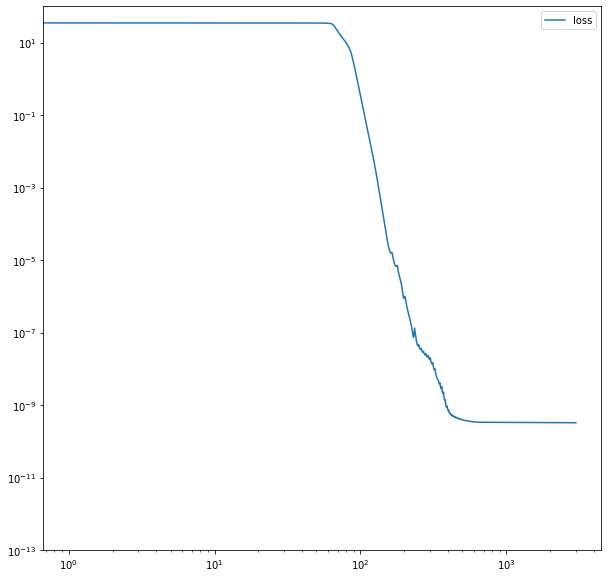

In [11]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
plt.legend()
plt.show()

In [12]:
N_test = 200000

para_test = lhs(d, N_test)
r = np.sqrt(para_test[:,0:1]*0.36)
t1 = para_test[:,1:2]*np.pi
t2 = para_test[:,2:3]*np.pi
t3 = para_test[:,3:4]*np.pi
t4 = para_test[:,4:5]*np.pi
t5 = para_test[:,5:6]*2.0*np.pi
X_test = 0.0*para_test
X_test[:, 0:1] = r*np.cos(t1)
X_test[:, 1:2] = r*np.sin(t1)*np.cos(t2)
X_test[:, 2:3] = r*np.sin(t1)*np.sin(t2)*np.cos(t3)
X_test[:, 3:4] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.cos(t4)
X_test[:, 4:5] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.cos(t5)
X_test[:, 5:6] = r*np.sin(t1)*np.sin(t2)*np.sin(t3)*np.sin(t4)*np.sin(t5)
z_test = sign_x(X_test)
X_test = np.hstack([X_test, z_test])

u_test = exact_u(X_test)
u_test = u_test.reshape((N_test,1))

X_test_torch = torch.tensor(X_test).double().to(device)
u_pred = func_model(func_params, X_test_torch).detach().cpu().numpy()

error = np.absolute(u_pred - u_test)

error_u_inf_r = np.linalg.norm(error, np.inf)/np.linalg.norm(u_test, np.inf)
print('Error u (relative inf-norm): %e' % (error_u_inf_r))
error_u_2r = np.linalg.norm(error,2)/np.linalg.norm(u_test,2)
print('Error u (relative 2-norm): %e' % (error_u_2r))
error_u_inf = np.linalg.norm(error, np.inf)
print('Error u (absolute inf-norm): %e' % (error_u_inf))
error_u_2 = np.linalg.norm(error,2)/np.sqrt(N_test)
print('Error u (absolute 2-norm): %e' % (error_u_2))

Error u (relative inf-norm): 4.922615e-05
Error u (relative 2-norm): 7.120056e-06
Error u (absolute inf-norm): 1.627561e-04
Error u (absolute 2-norm): 6.705199e-06
